In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
from keras.layers.core import Flatten
from keras.layers.core import Dense

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

C:\Users\jinan\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

In [3]:
# Initialising the RNN
regressor = Sequential()

In [4]:
df = pd.read_csv("training.csv")
#df.to_csv("data.csv",encoding="UTF-8")

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,...,reviews_id,reviews.numHelpful,rating,sourceURLs,text,title,userCity,userProvince,username,upc
0,8022,8031,985635257,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",2015-09-11T18:17:13Z,2018-02-05T08:35:02Z,44600015996,"clorox/12992356,044600015996,cloroxdisinfectin...",Clorox,...,NaN,NaN,5,https://redsky.target.com/groot-domain-api/v1/...,"We are all coughing, sneezing and running low ...",Great When Everyone In The House Is Sick,America,NaN,336321266,44600015996
1,20469,20483,683739812,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",2016-04-06T12:31:21Z,2018-02-05T11:26:19Z,44600080338,"044600080338,cloroxdisinfectingbathroomcleaner...",AmazonUs/CLOO7,...,28185324.0,NaN,5,https://www.walmart.com/reviews/product/254837...,"I use these wipes everyday, both at home and a...",Wonderful Product,Europe,NaN,731826734,"44,600,080,338,044,600,000,000"
2,69474,69515,547628512,Warner Bros.,"Movies, Music & Books,Ways To Shop Entertainme...",2017-03-03T17:01:44Z,2018-02-05T08:36:40Z,8.84E+11,"883929530380,warnerbros/51818404,0883929530380...",WarnerBrothers,...,NaN,0.0,5,http://reviews.bestbuy.com/3545/5644305/review...,This movie made the wife and I laugh when we w...,"Cute, funny and great for whole family",Australia,NaN,682704279,8.84E+11
3,24304,24321,840729767,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",2016-07-26T21:32:40Z,2018-02-05T10:22:44Z,NaN,"warnerhomevideo/15773884,883929388448,godzilla...",Test,...,NaN,0.0,4,http://reviews.bestbuy.com/3545/6435036/review...,Entertaining but the first 3/4 of the movie is...,Good but not Great,India,NaN,708707405,8.84E+11
4,32040,32067,707210344,Head & Shoulders,"Personal Care,Hair Care,Anti-Dandruff,Conditio...",2017-01-07T20:55:54Z,2018-02-05T11:26:34Z,37000143093,"037000143093,headshouldersdryscalpcareconditio...",Procter & Gamble Company,...,NaN,NaN,5,https://redsky.target.com/groot-domain-api/v1/...,I received the Head Shoulders Dry Scalp formul...,No More Dandruff Snow Showers,UK,NaN,139866001,"37,000,143,086,037,000,000,000"


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'brand', 'categories', 'dateAdded',
       'dateUpdated', 'ean', 'keys', 'manufacturer', 'manufacturerNumber',
       'name', 'reviewsdate', 'dateSeen', 'didPurchase', 'doRecommend',
       'reviews_id', 'reviews.numHelpful', 'rating', 'sourceURLs', 'text',
       'title', 'userCity', 'userProvince', 'username', 'upc'],
      dtype='object')

In [7]:
df.didPurchase = (df.didPurchase)*1

In [8]:
df.doRecommend = (df.doRecommend)*1

In [9]:
df['doRecommend']

0          1
1          1
2          1
3          1
4        NaN
5          1
6          1
7          1
8        NaN
9          1
10         1
11         0
12         1
13         1
14         0
15         1
16         1
17         1
18         1
19         0
20         1
21         1
22         1
23       NaN
24         1
25         0
26         1
27         1
28         1
29         1
        ... 
56772      0
56773      1
56774      1
56775    NaN
56776      1
56777    NaN
56778      1
56779      1
56780      1
56781    NaN
56782      1
56783      1
56784      0
56785      1
56786    NaN
56787      1
56788      1
56789      1
56790      1
56791      1
56792      1
56793      1
56794      0
56795      1
56796      1
56797      1
56798      1
56799      1
56800      1
56801      1
Name: doRecommend, Length: 56802, dtype: object

In [10]:
df['doRecommend'] = df['doRecommend'].fillna(1)

In [11]:
df['doRecommend'] 

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       0
12       1
13       1
14       0
15       1
16       1
17       1
18       1
19       0
20       1
21       1
22       1
23       1
24       1
25       0
26       1
27       1
28       1
29       1
        ..
56772    0
56773    1
56774    1
56775    1
56776    1
56777    1
56778    1
56779    1
56780    1
56781    1
56782    1
56783    1
56784    0
56785    1
56786    1
56787    1
56788    1
56789    1
56790    1
56791    1
56792    1
56793    1
56794    0
56795    1
56796    1
56797    1
56798    1
56799    1
56800    1
56801    1
Name: doRecommend, Length: 56802, dtype: int64

In [12]:
training_set = df[['id','username','rating','doRecommend','didPurchase']]

In [13]:
training_set['didPurchase'] = training_set['didPurchase'].fillna(1)

C:\Users\jinan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
training_set.head()

,id,username,rating,doRecommend,didPurchase
0,985635257,336321266,5,1,1
1,683739812,731826734,5,1,0
2,547628512,682704279,5,1,1
3,840729767,708707405,4,1,1
4,707210344,139866001,5,1,1


In [15]:
training_set = training_set.iloc[:, 2:3].values

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

C:\Users\jinan\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
# Getting the inputs and the ouputs
x_train =  training_set[0:999]
y_train = training_set[1:1000]


In [17]:
print(y_train.shape)
print(x_train.shape)

(999, 1)
(999, 1)


In [18]:
# Reshaping
x_train = x_train.reshape(999,1,1)
print(x_train.shape)
# Reshaping
#y_train = y_train.reshape(999,4,1)
print(y_train.shape)

(999, 1, 1)
(999, 1)


In [19]:
#print(X_train)

In [20]:
# Adding the input layer and the LSTM layer
# input_shape=(None, 1) = input_shae=(timestep_count, features_count)
regressor.add(LSTM(12, activation='relu', input_shape=(None,1)))
regressor.add(Dense(8, activation='softmax'))
# Adding the output layer
regressor.add(Dense(1))


# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Fitting the RNN to the Training set
regressor.fit(x_train, y_train, batch_size=20, epochs=200)

Epoch 1/200
999/999 [==============================] - 1s 1ms/step - loss: 0.8320
Epoch 2/200
999/999 [==============================] - 0s 117us/step - loss: 0.6429
Epoch 3/200
999/999 [==============================] - 0s 154us/step - loss: 0.4846 0s - loss: 0.53
Epoch 4/200
999/999 [==============================] - 0s 148us/step - loss: 0.3529
Epoch 5/200
999/999 [==============================] - 0s 144us/step - loss: 0.2436
Epoch 6/200
999/999 [==============================] - 0s 152us/step - loss: 0.1600
Epoch 7/200
999/999 [==============================] - 0s 151us/step - loss: 0.1080
Epoch 8/200
999/999 [==============================] - 0s 148us/step - loss: 0.0865
Epoch 9/200
999/999 [==============================] - 0s 148us/step - loss: 0.0808
Epoch 10/200
999/999 [==============================] - 0s 147us/step - loss: 0.0798
Epoch 11/200
999/999 [==============================] - 0s 148us/step - loss: 0.0795
Epoch 12/200
999/999 [==============================] - 0s 9

999/999 [==============================] - 0s 119us/step - loss: 0.0737
Epoch 98/200
999/999 [==============================] - 0s 125us/step - loss: 0.0737
Epoch 99/200
999/999 [==============================] - 0s 134us/step - loss: 0.0736
Epoch 100/200
999/999 [==============================] - 0s 130us/step - loss: 0.0736
Epoch 101/200
999/999 [==============================] - 0s 135us/step - loss: 0.0737 0s - loss: 0.079
Epoch 102/200
999/999 [==============================] - 0s 148us/step - loss: 0.0737
Epoch 103/200
999/999 [==============================] - 0s 122us/step - loss: 0.0736
Epoch 104/200
999/999 [==============================] - 0s 124us/step - loss: 0.0736
Epoch 105/200
999/999 [==============================] - 0s 118us/step - loss: 0.0737
Epoch 106/200
999/999 [==============================] - 0s 143us/step - loss: 0.0736
Epoch 107/200
999/999 [==============================] - 0s 145us/step - loss: 0.0736
Epoch 108/200
999/999 [==============================

999/999 [==============================] - 0s 139us/step - loss: 0.0736
Epoch 193/200
999/999 [==============================] - 0s 139us/step - loss: 0.0737
Epoch 194/200
999/999 [==============================] - 0s 130us/step - loss: 0.0736
Epoch 195/200
999/999 [==============================] - 0s 126us/step - loss: 0.0736
Epoch 196/200
999/999 [==============================] - 0s 149us/step - loss: 0.0735
Epoch 197/200
999/999 [==============================] - 0s 145us/step - loss: 0.0736
Epoch 198/200
999/999 [==============================] - 0s 145us/step - loss: 0.0736
Epoch 199/200
999/999 [==============================] - 0s 142us/step - loss: 0.0735
Epoch 200/200
999/999 [==============================] - 0s 139us/step - loss: 0.0736


In [22]:
# evaluate the model
scores = regressor.evaluate(x_train, y_train)
print("\n%s: %.2f%%" % (regressor.metrics_names, scores*100))

999/999 [==============================] - 0s 98us/step

['loss']: 7.35%


In [23]:
# Making the predictions and visualising the results

test_set = pd.read_csv("test.csv")
real_test_data = test_set[['id','username','didPurchase','rating']]

In [24]:
real_test_data.shape

(14201, 4)

In [25]:
real_test_data['didPurchase'].fillna(True)

0         True
1         True
2         True
3         True
4         True
5         True
6        False
7        False
8         True
9         True
10       False
11        True
12        True
13        True
14       False
15        True
16        True
17        True
18        True
19        True
20        True
21       False
22        True
23        True
24        True
25        True
26       False
27        True
28        True
29        True
         ...  
14171    False
14172     True
14173     True
14174     True
14175     True
14176    False
14177     True
14178     True
14179    False
14180    False
14181    False
14182    False
14183     True
14184     True
14185    False
14186     True
14187     True
14188     True
14189    False
14190     True
14191     True
14192    False
14193    False
14194     True
14195     True
14196     True
14197     True
14198    False
14199    False
14200     True
Name: didPurchase, Length: 14201, dtype: bool

In [26]:
real_test_data.didPurchase = (real_test_data.didPurchase)*1

C:\Users\jinan\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [27]:
real_test_data['didPurchase'] = real_test_data['didPurchase'].fillna(1)

C:\Users\jinan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
real_test_data.head

<bound method NDFrame.head of               id   username  didPurchase  rating
0      528392070  955631380            1       5
1      357172348  204261674            1       5
2      840729767   85823336            1       5
3      293822251   93778309            1       5
4      410538000  942827928            1       5
5      436441872   76670171            1       5
6      883374506  157382496            0       5
7       23105503  829592661            0       5
8      840729767  488964591            1       5
9      652307571  382201392            1       5
10      23105503  287924721            0       5
11     840729767    1243416            1       5
12     284960798  559030407            1       5
13     488088864  585472984            1       1
14     985635257  450930244            0       5
15     547628512  989292548            1       5
16     930396708  681669715            1       4
17     985635257  126430085            1       5
18     679312649  635258241            

In [29]:
real_test_data = real_test_data.head(100)

In [30]:
real_test_data.shape

(100, 4)

In [31]:
# Getting the predicted data
inputs = real_test_data
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (100,4,1))
predicted_data = regressor.predict(inputs)
predicted_data= sc.inverse_transform(predicted_data)
print(predicted_data)

[[3.9184093]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.3770905]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]
 [3.9184093]

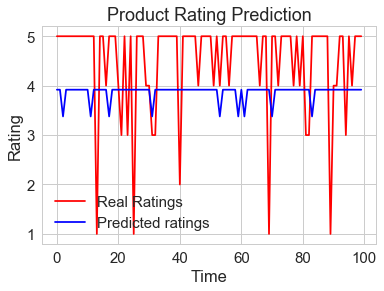

In [35]:
# Visualising the results
plt.plot(real_test_data['rating'], color='red', label='Real Ratings')
plt.plot(predicted_data, color='blue', label='Predicted ratings')
plt.title('Product Rating Prediction')
plt.xlabel('Time')
plt.ylabel('Rating')
plt.legend()
plt.show()

In [36]:
import math
from sklearn.metrics import mean_squared_error
print(real_test_data)
print(predicted_data)
rmse = math.sqrt(mean_squared_error(real_test_data['rating'], predicted_data))
print("RMSE =", rmse)

           id   username  didPurchase  rating
0   528392070  955631380            1       5
1   357172348  204261674            1       5
2   840729767   85823336            1       5
3   293822251   93778309            1       5
4   410538000  942827928            1       5
5   436441872   76670171            1       5
6   883374506  157382496            0       5
7    23105503  829592661            0       5
8   840729767  488964591            1       5
9   652307571  382201392            1       5
10   23105503  287924721            0       5
11  840729767    1243416            1       5
12  284960798  559030407            1       5
13  488088864  585472984            1       1
14  985635257  450930244            0       5
15  547628512  989292548            1       5
16  930396708  681669715            1       4
17  985635257  126430085            1       5
18  679312649  635258241            1       5
19  357172348  997896312            1       5
20  689536216  691478978          

### Simple RNN

In [37]:
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dropout

In [38]:
# Adding the input layer and the LSTM layer
# input_shape=(None, 1) = input_shape=(timestep_count, features_count)
#regressor.add(LSTM(12, activation='relu', input_shape = (None,1),kernel_initializer='uniform',return_sequences=True))keras.layers.Dropout
model = Sequential()
model.add(SimpleRNN(128,input_shape = (None,1)))
# Adding the output layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid',kernel_initializer='uniform'))


# Compiling the RNN
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
y_train = training_set[1:10000]

In [39]:
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
999/999 [==============================] - 1s 686us/step - loss: 0.6256
Epoch 2/100
999/999 [==============================] - 0s 71us/step - loss: 0.4988
Epoch 3/100
999/999 [==============================] - 0s 68us/step - loss: 0.4588
Epoch 4/100
999/999 [==============================] - 0s 97us/step - loss: 0.4555
Epoch 5/100
999/999 [==============================] - 0s 88us/step - loss: 0.4524
Epoch 6/100
999/999 [==============================] - 0s 91us/step - loss: 0.4517
Epoch 7/100
999/999 [==============================] - 0s 99us/step - loss: 0.4535
Epoch 8/100
999/999 [==============================] - 0s 98us/step - loss: 0.4528: 0s - loss: 0.462
Epoch 9/100
999/999 [==============================] - 0s 93us/step - loss: 0.4471
Epoch 10/100
999/999 [==============================] - 0s 95us/step - loss: 0.4468
Epoch 11/100
999/999 [==============================] - 0s 84us/step - loss: 0.4505
Epoch 12/100
999/999 [==============================] - 0s 85us/st

999/999 [==============================] - 0s 92us/step - loss: 0.4439
Epoch 99/100
999/999 [==============================] - 0s 93us/step - loss: 0.4440
Epoch 100/100
999/999 [==============================] - ETA: 0s - loss: 0.451 - 0s 96us/step - loss: 0.4440


In [40]:
# evaluate the model
scores = model.evaluate(x_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names, scores*100))

999/999 [==============================] - 0s 109us/step

['loss']: 44.10%
